Begun 3/26/24

Based on the results in nb7 (finding that the remaining bias seemed to have to do with the covariance weighting), we want to test in this notebook whether the estimator is unbiased when a realistic noise profile is added. I will calculate the noise power spectra from a single depth-1 map (which will just be the autospectra since they are noise dominated maps) and use that to generate a new noise map for every iteration that we can add to the realization of the signal map.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [3]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [4]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [5]:
def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [6]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [8]:
# Loading in depth-1 map, calculating power spectra without filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2 = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_T,depth1_T,1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_E,depth1_E,1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_B,depth1_B,1.0,w2,lmax,bin_size)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


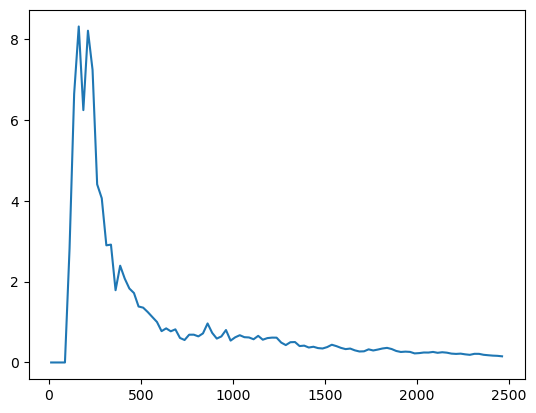

In [9]:
plt.plot(ell_b,depth1_BB)

In [10]:
# Interpolating noise data to fill every ell to put into synfast
from scipy.interpolate import CubicSpline

In [11]:
cs_TT = CubicSpline(ell_b, depth1_TT)
cs_EE = CubicSpline(ell_b, depth1_EE)
cs_BB = CubicSpline(ell_b, depth1_BB)

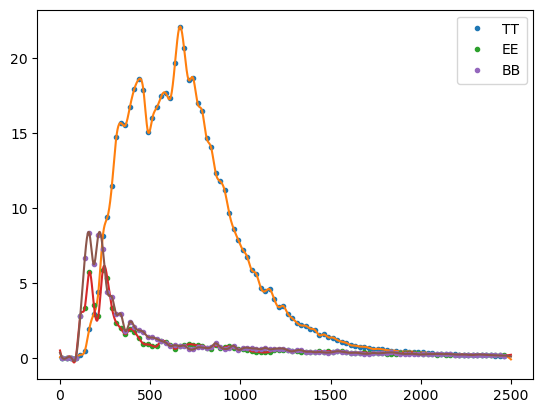

In [12]:
ell_test = np.arange(0,2501)
plt.plot(ell_b,depth1_TT, marker=".", ls="none",label = "TT")
plt.plot(ell_test, cs_TT(ell_test))
plt.plot(ell_b,depth1_EE, marker=".", ls="none",label = "EE")
plt.plot(ell_test, cs_EE(ell_test))
plt.plot(ell_b,depth1_BB, marker=".", ls="none",label = "BB")
plt.plot(ell_test, cs_BB(ell_test))
plt.legend()
plt.show()
plt.close()

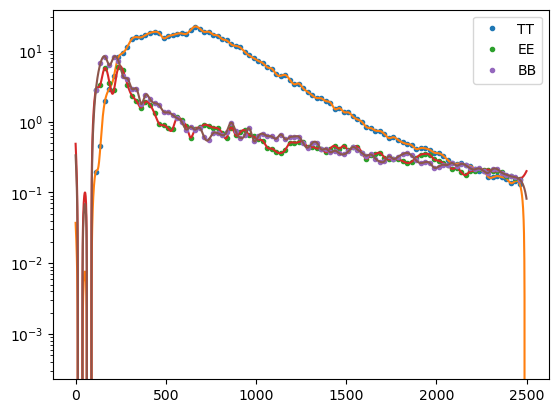

In [13]:
plt.semilogy(ell_b,depth1_TT, marker=".", ls="none",label = "TT")
plt.semilogy(ell_test, cs_TT(ell_test))
plt.semilogy(ell_b,depth1_EE, marker=".", ls="none",label = "EE")
plt.semilogy(ell_test, cs_EE(ell_test))
plt.semilogy(ell_b,depth1_BB, marker=".", ls="none",label = "BB")
plt.semilogy(ell_test, cs_BB(ell_test))
plt.legend()
plt.show()
plt.close()

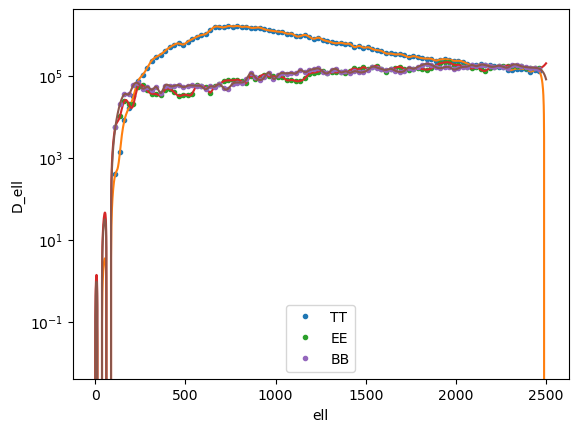

In [14]:
plt.semilogy(ell_b,ell_b*(ell_b+1)*depth1_TT / (2*np.pi), marker=".", ls="none",label = "TT")
plt.semilogy(ell_test, ell_test*(ell_test+1)*cs_TT(ell_test)/ (2*np.pi))
plt.semilogy(ell_b,ell_b*(ell_b+1)*depth1_EE / (2*np.pi), marker=".", ls="none",label = "EE")
plt.semilogy(ell_test, ell_test*(ell_test+1)*cs_EE(ell_test)/ (2*np.pi))
plt.semilogy(ell_b,ell_b*(ell_b+1)*depth1_BB / (2*np.pi), marker=".", ls="none",label = "BB")
plt.semilogy(ell_test, ell_test*(ell_test+1)*cs_BB(ell_test)/ (2*np.pi))
plt.ylabel('D_ell')
plt.xlabel('ell')
plt.legend()
plt.show()
plt.close()

In [28]:
noise_TT = np.zeros(arr_len)
noise_EE = np.zeros(arr_len)
noise_BB = np.zeros(arr_len)
# Absolute values to handle some negative numbers in spline fit due to filtering
# Cutoff above 2500 to ensure that we only use noise info in the range where we calculated it
noise_TT[2:2501] = np.abs(cs_TT(ell[2:2501]))
noise_EE[2:2501] = np.abs(cs_EE(ell[2:2501]))
noise_BB[2:2501] = np.abs(cs_BB(ell[2:2501]))

In [29]:
noise_TT[2500]

0.10631006180055617

In [32]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# The new thing here is generating a random noise realization from the noise spectra (no TE spectra - just pass None)
# and adding the noise map to the sim maps before rotation and attempting to recover the angle.
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding noise to sims before rotating
    unrot_sim_maps = (unrot_sim_maps[0]+noise_maps[0],unrot_sim_maps[1]+noise_maps[1],unrot_sim_maps[2]+noise_maps[2])
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:01:12<00:00, 12.24s/it]


Median of full sky percent error, map based estimator: -0.020306590798047086
Mean of full sky percent error, map based estimator: -0.02030659079803802
Std dev of full sky percent error, map based estimator: 6.850749801002151e-14


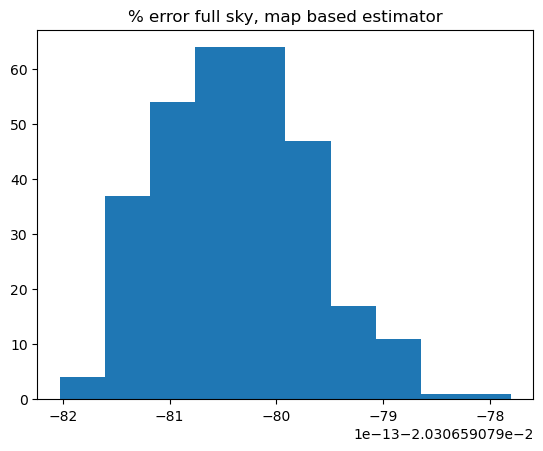

Median of full sky percent error: 0.08556816336288131
Mean of full sky percent error: 0.07656860777044941
Std dev of full sky percent error: 0.15907553831759494


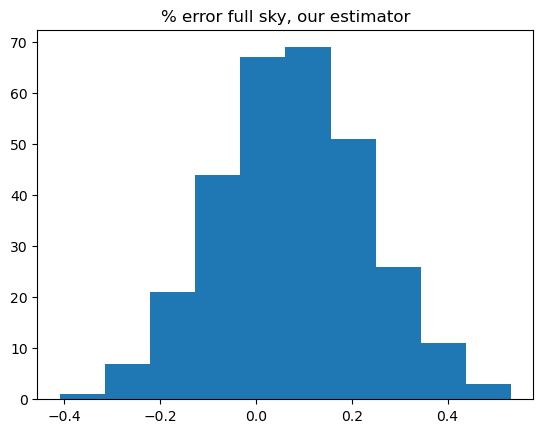

Median of full sky percent error EB estimator: -0.8208465507173246
Mean of full sky percent error EB estimator: -0.8273854720208333
Std dev of full sky percent error EB estimator: 0.24299822229044904


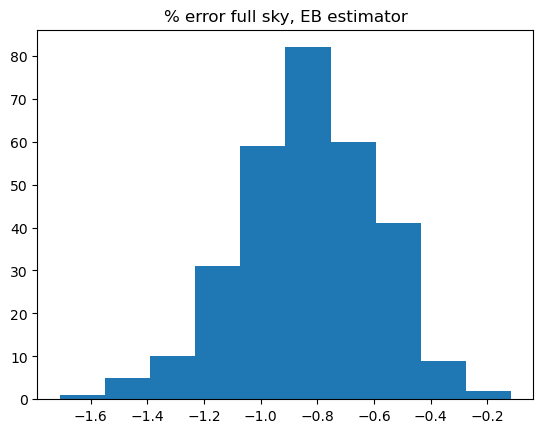

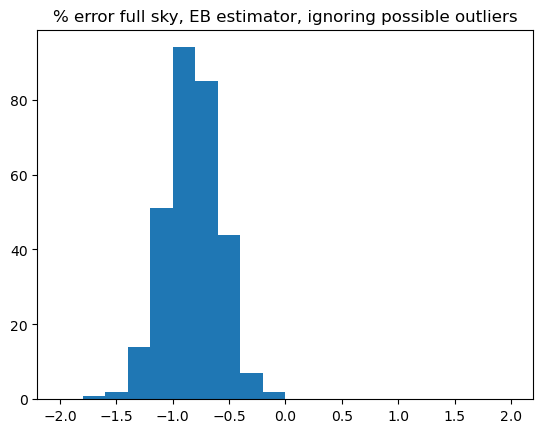

Median of full sky angles Unrot EB estimator: 0.00010820992520173148
Mean of full sky angles Unrot EB estimator: 0.00018981057281474908
Std dev of full sky angles Unrot EB estimator: 0.0018055808573874173


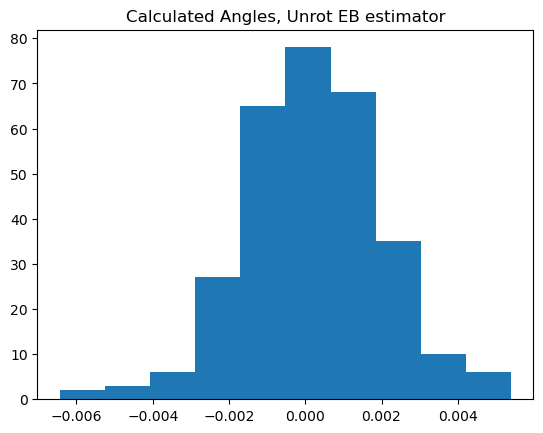

Median of full sky mean TT ratio: 1.0001601691951767
Mean of full sky mean TT ratio: 1.0001430436479508
Std dev of full sky mean TT ratio: 0.0014610602458719004


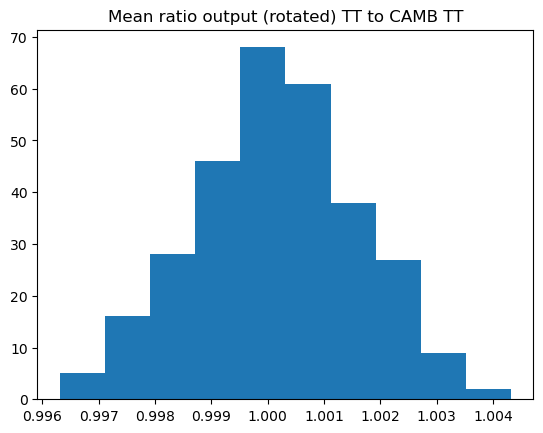

In [33]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [34]:
def mod_null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb) # TTesting what happens if I neglect EB in the covariance
    # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def mod_sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [mod_null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [35]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Also uses noise spectra to inject noise

# The new thing in this run is getting rid of EB spectrum in covariance of EB estimator
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
mod_output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding noise to sims before rotating
    unrot_sim_maps = (unrot_sim_maps[0]+noise_maps[0],unrot_sim_maps[1]+noise_maps[1],unrot_sim_maps[2]+noise_maps[2])
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    mod_output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = mod_sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = mod_sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
mod_output_angles_only = np.array(output_angles)[:,0]
mod_output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
mod_output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
mod_percent_diff = 100.0*(mod_output_angles_only - rot_degs)/rot_degs
mod_percent_diff_eb = 100.0*(mod_output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:01:45<00:00, 12.35s/it]


Median of full sky percent error, map based estimator: -0.020306590798047086
Mean of full sky percent error, map based estimator: -0.020306590798040647
Std dev of full sky percent error, map based estimator: 7.143799909647251e-14


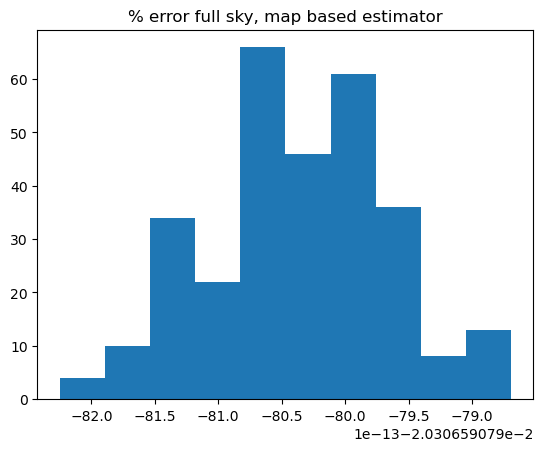

Median of full sky percent error: 0.07254975620549775
Mean of full sky percent error: 0.07645530801341557
Std dev of full sky percent error: 0.15535239681755864


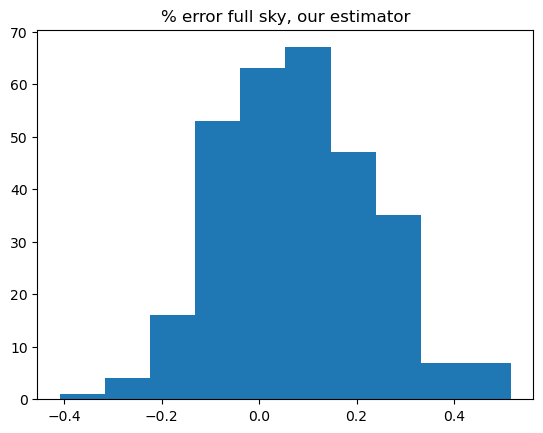

Median of full sky percent error EB estimator: -0.7163989745166244
Mean of full sky percent error EB estimator: -0.7266027234741271
Std dev of full sky percent error EB estimator: 0.24998669455391423


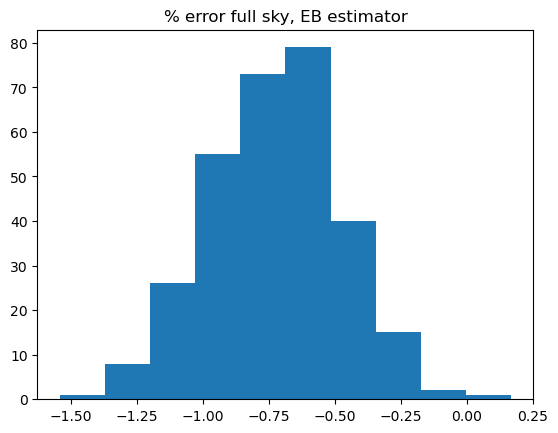

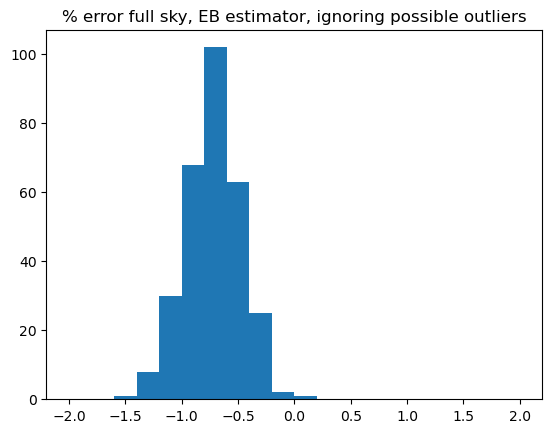

Median of full sky angles Unrot EB estimator: 0.00013108754125236002
Mean of full sky angles Unrot EB estimator: -5.336312442520021e-05
Std dev of full sky angles Unrot EB estimator: 0.001845921612333838


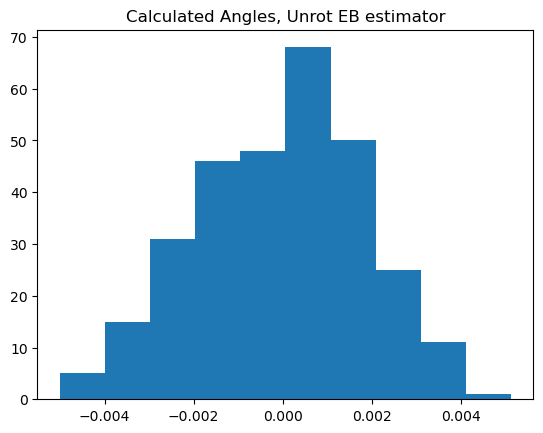

Median of full sky mean TT ratio: 0.9999609428888866
Mean of full sky mean TT ratio: 1.000052045825825
Std dev of full sky mean TT ratio: 0.0015378741860597389


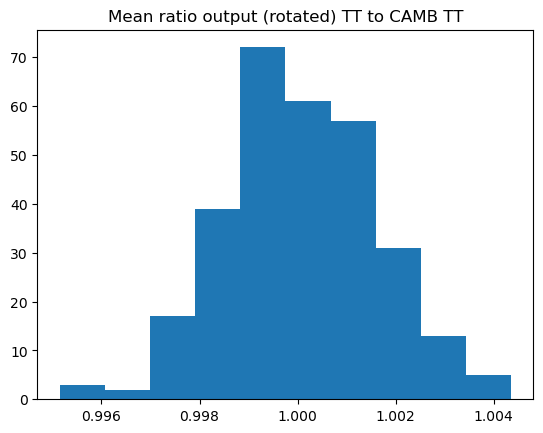

In [36]:
mod_percent_diff = 100.0*(mod_output_angles_only - rot_degs)/rot_degs
mod_percent_diff_eb = 100.0*(mod_output_null_eb_angles_only - rot_degs)/rot_degs

output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(mod_percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(mod_percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(mod_percent_diff)))
plt.hist(mod_percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(mod_percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(mod_percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(mod_percent_diff_eb)))
plt.hist(mod_percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(mod_percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(mod_output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(mod_output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(mod_output_unrot_null_eb_angles_only)))
plt.hist(mod_output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

It doesn't seem that the EB part of the covariance was the real issue. It is also unclear why the standard deviation of the distribution is so similar to the noiseless sims...

Another possibility for the cause of the bias is that there is some effect caused by injecting this rotation in map space and then trying to recover it in PS space. To test this, I will generate an EB spectrum from a map with a 1 deg rotation, then trying to add that spectrum directly to the maps with synfast before using the estimators to recover the angle.

In [30]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# Doing the rotation in PS space instead of map space
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT+noise_TT,ClTE,ClEE+noise_EE,ClBB+noise_BB),nside)
    #np.random.seed(SEEDVALUE)
    #noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding noise to sims before rotating
    #unrot_sim_maps = (unrot_sim_maps[0]+noise_maps[0],unrot_sim_maps[1]+noise_maps[1],unrot_sim_maps[2]+noise_maps[2])
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB+noise_BB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE+noise_EE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB+noise_BB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE+noise_EE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB+noise_BB)-(ClEE+noise_EE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at 1 deg to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT+noise_TT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:05:04<00:00, 13.01s/it]


Median of full sky percent error, map based estimator: -108.07753538379234
Mean of full sky percent error, map based estimator: -108.08342488491544
Std dev of full sky percent error, map based estimator: 0.011688061507457832


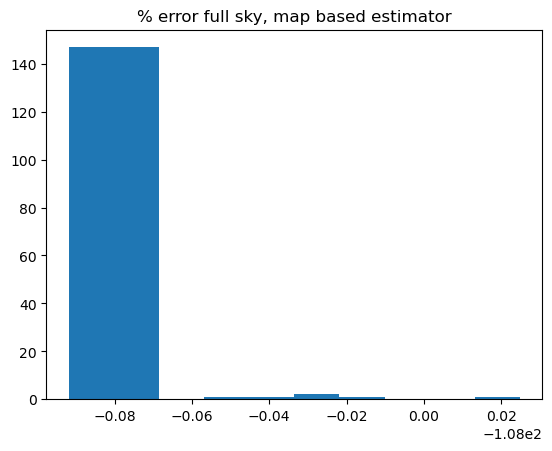

Median of full sky percent error: 14.661714645281121
Mean of full sky percent error: 14.764813530487451
Std dev of full sky percent error: 0.3806534869785463


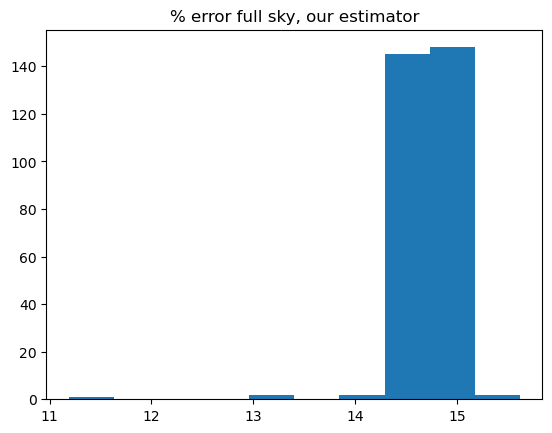

Median of full sky percent error EB estimator: -0.0008383490051500075
Mean of full sky percent error EB estimator: -0.00107537746169258
Std dev of full sky percent error EB estimator: 0.00026186048211850207


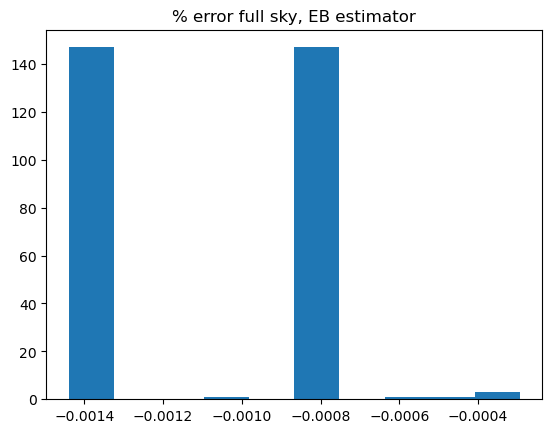

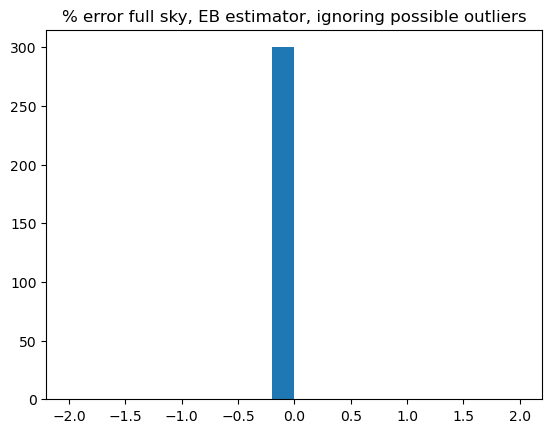

Median of full sky angles Unrot EB estimator: -1.485399720955489e-06
Mean of full sky angles Unrot EB estimator: -3.894118309827551e-06
Std dev of full sky angles Unrot EB estimator: 2.652381717667174e-06


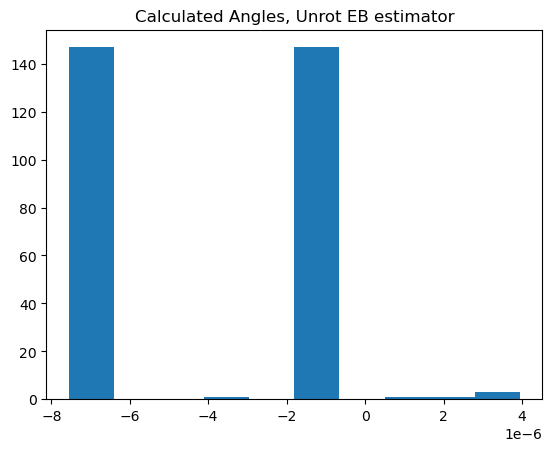

Median of full sky mean TT ratio: 470.0437203974075
Mean of full sky mean TT ratio: 470.12202195284567
Std dev of full sky mean TT ratio: 0.1757852290576692


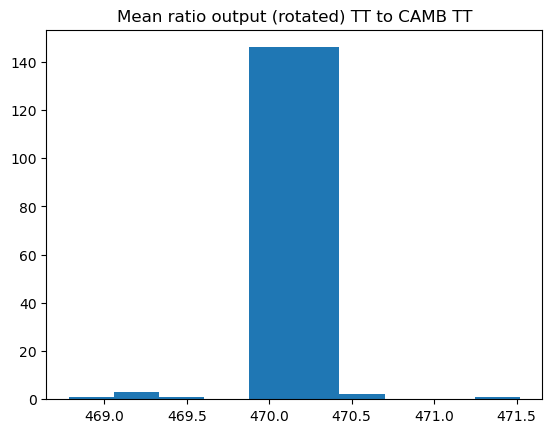

In [31]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

I seem to have screwed something up about the seeding of the random maps between the unrotated and rotated maps - every method (map-based, our estimator, and TT ratio) that compares them is really screwed up. The EB estimator, however, only looks at one or the other, and it seems perfectly unbiased for both now!

I'm going to run a few more tests to see if this is true without noise and to make sure that the results hold up when using a random distribution of angles.

In [37]:
# Test to see if bias goes away from injecting rotation in PS space without noise
# This will tell us if there was an issue with the covariance or if the covariance was just picking
# up this bias from injecting the rotations in map space

# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Still doing the rotation in PS space instead of map space

min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Trying it without seeds to see if that was part of the issue with the rot and unrot maps not agreeing
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
 
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at 1 deg to generate new sim rotated maps
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:03:46<00:00, 12.75s/it]


Median of full sky percent error, map based estimator: -99.99475934781472
Mean of full sky percent error, map based estimator: -99.97546982452276
Std dev of full sky percent error, map based estimator: 0.22869801154133454


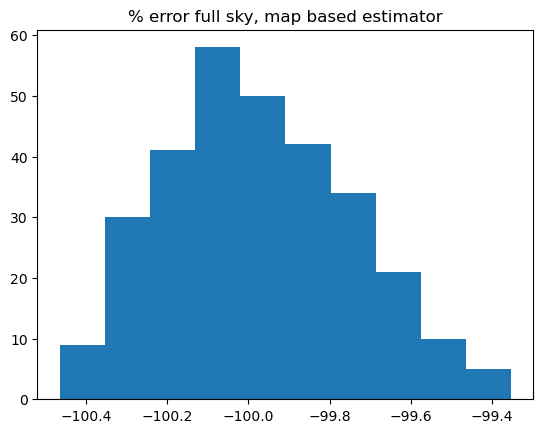

Median of full sky percent error: -92.83171055294702
Mean of full sky percent error: -92.81885154700512
Std dev of full sky percent error: 0.10758009521163545


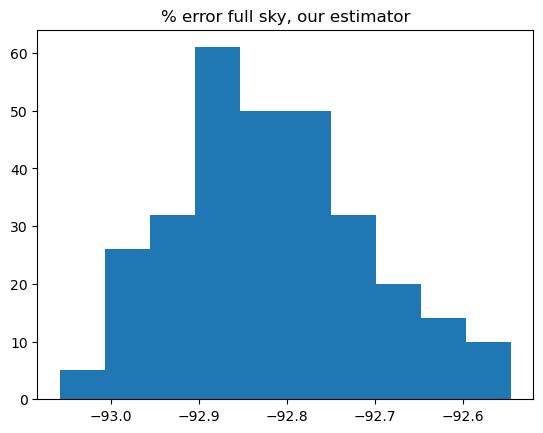

Median of full sky percent error EB estimator: -0.8471865608041196
Mean of full sky percent error EB estimator: -0.8444948821798887
Std dev of full sky percent error EB estimator: 0.2569303472047077


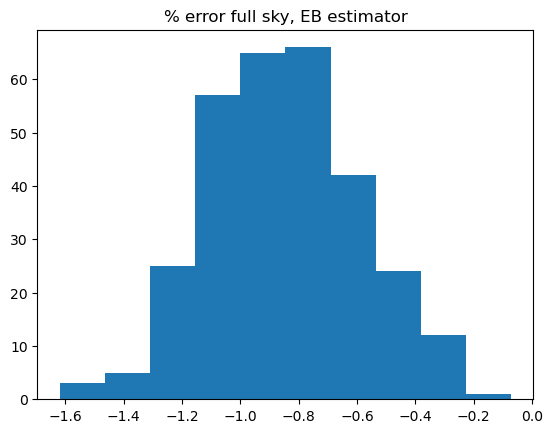

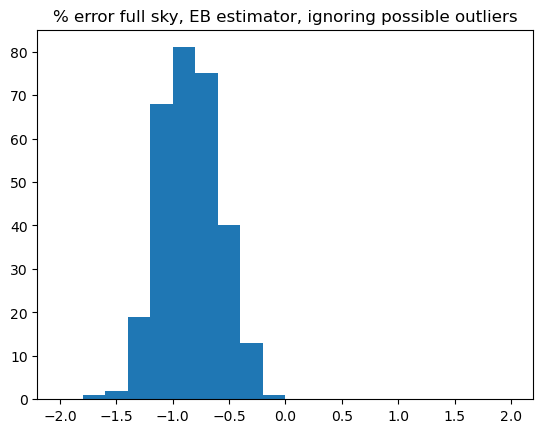

Median of full sky angles Unrot EB estimator: 0.00015451834526468072
Mean of full sky angles Unrot EB estimator: 8.919231874798923e-05
Std dev of full sky angles Unrot EB estimator: 0.001807720948293652


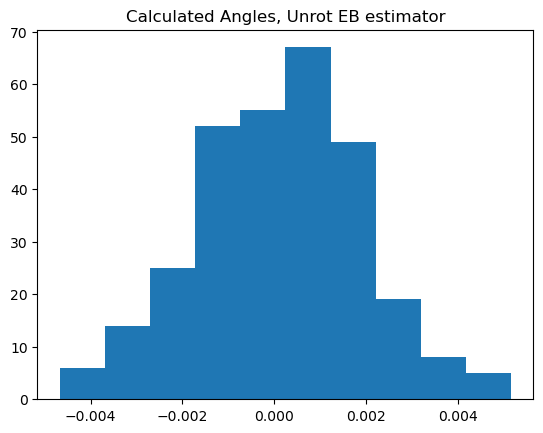

Median of full sky mean TT ratio: 1.0000153172265702
Mean of full sky mean TT ratio: 0.999982353021443
Std dev of full sky mean TT ratio: 0.0016190995663236945


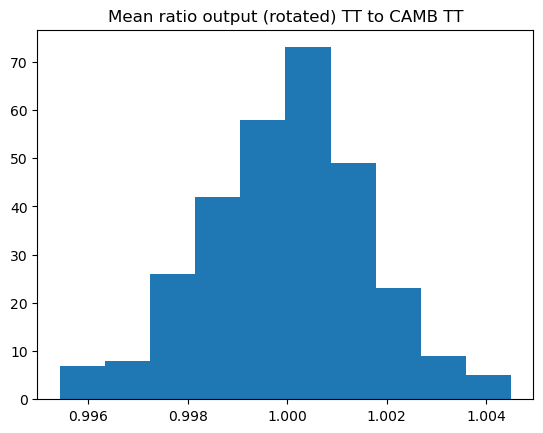

In [38]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

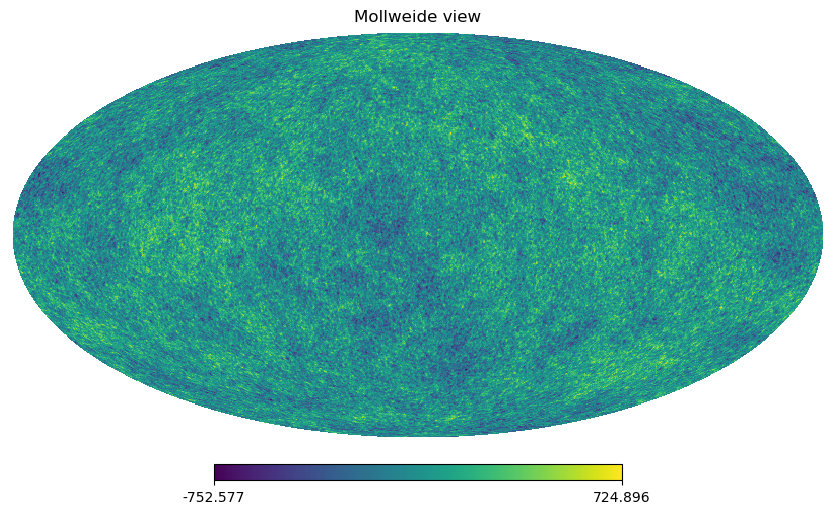

In [44]:
# Testing whether seeds actually produce the same synfast output
np.random.seed(4)
test1 = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
test2 = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
hp.mollview(test1[0]-test2[0])

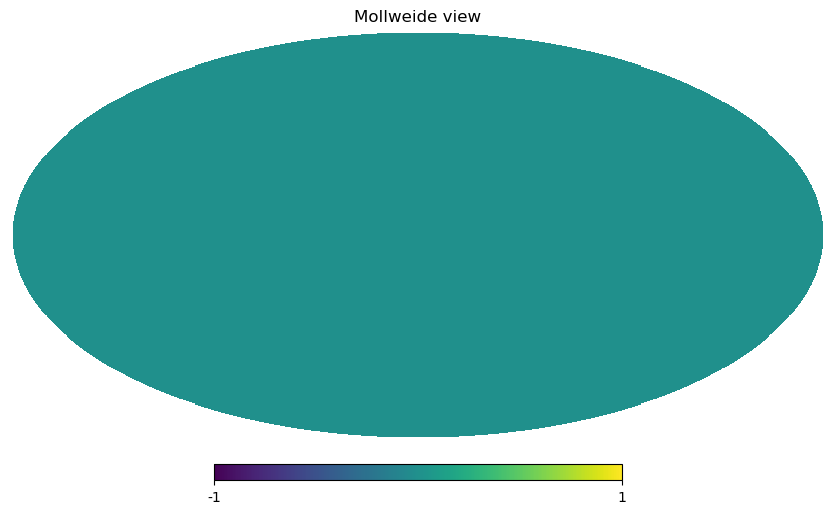

In [45]:
np.random.seed(4)
test1 = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
np.random.seed(4)
test2 = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
hp.mollview(test1[0]-test2[0])

In [56]:
# Test to make sure bias stays away when using a random distribution of angles

# Doing 300 sims of full sky maps with an ell range of 200-1000
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# Doing the rotation in PS space instead of map space
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.random.normal(0, 5, size=(N_sims))
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Trying to use the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    # Trying to make the reference map without noise to see if that affects things
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    # Rotating just the signal, not the noise. Adding noise in when making sims below
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at random angles to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    # Generating noise
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding them together
    unrot_sim_maps = unrot_sim_maps + noise_maps
    rot_sim_maps = rot_sim_maps + noise_maps
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Scaling up to a larger test range for the random angles
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-15.0,angle_max_deg=15.0,num_pts=20000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:10:07<00:00, 14.02s/it]


Median of full sky percent error, map based estimator: -2.7406582563898234
Mean of full sky percent error, map based estimator: -2.823175552720984
Std dev of full sky percent error, map based estimator: 0.8295064705528936


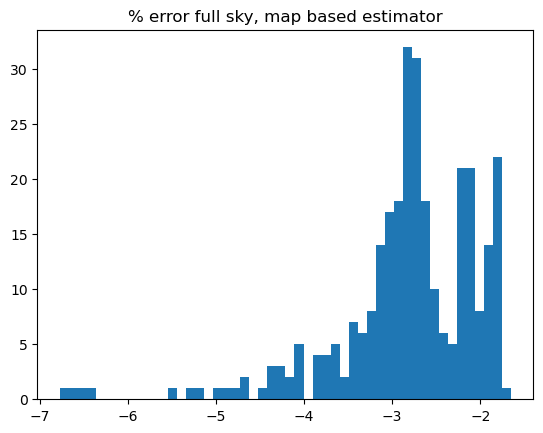

Median of full sky percent error: -0.8166530283353202
Mean of full sky percent error: -0.7424502003595437
Std dev of full sky percent error: 0.5132645312048552


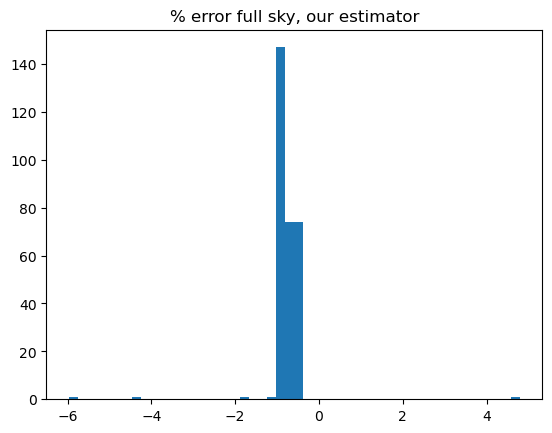

Median of full sky percent error EB estimator: -0.6558538107051355
Mean of full sky percent error EB estimator: -0.6232965020437412
Std dev of full sky percent error EB estimator: 1.6603988410996655


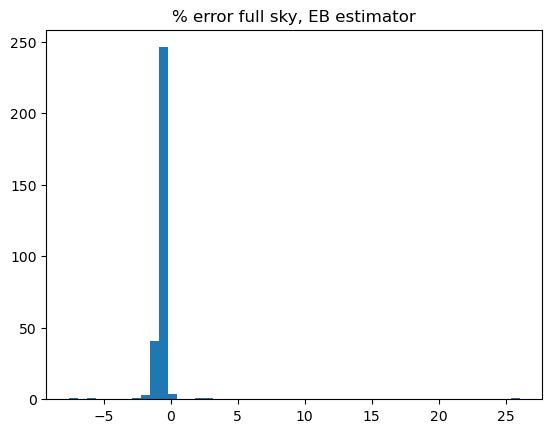

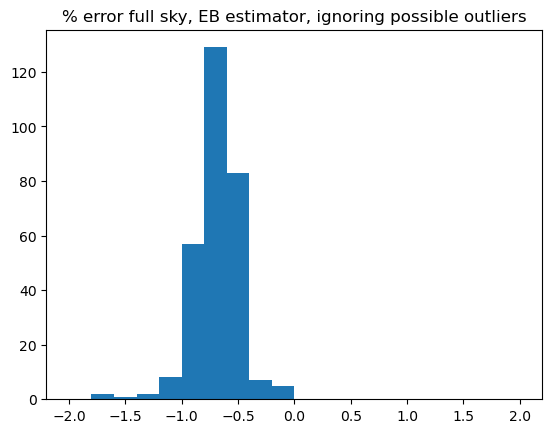

Median of full sky angles Unrot EB estimator: 0.00021688542556177887
Mean of full sky angles Unrot EB estimator: 5.874389197618693e-05
Std dev of full sky angles Unrot EB estimator: 0.0009762400899147656


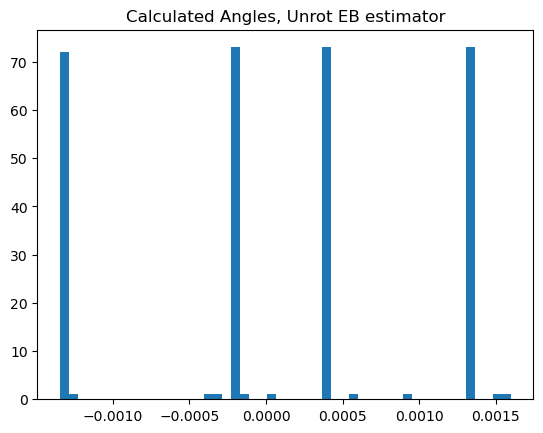

Median of full sky mean TT ratio: 0.9997754308205771
Mean of full sky mean TT ratio: 0.9995913151610788
Std dev of full sky mean TT ratio: 0.0012934701434788522


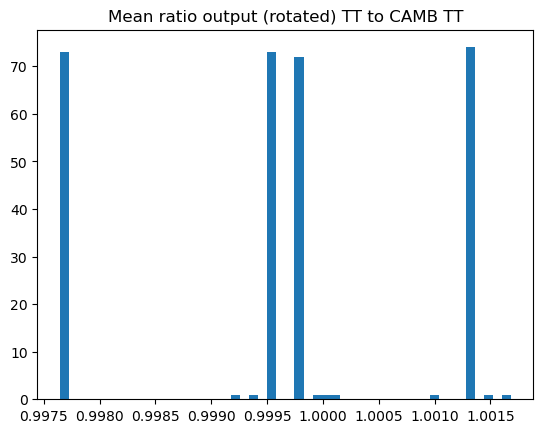

In [60]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()

In [61]:
# Test to see if bias goes away from injecting rotation in PS space without noise, but this time with the
# appropriate seeds since that clearly does matter

# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles
# Still doing the rotation in PS space instead of map space

min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    # Using the seeds to ensure the signal is the same between unrotated and rotated maps
    SEEDVALUE = np.random.randint(0,100)
    np.random.seed(SEEDVALUE)
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
 
    # Calculating rotated TE,EE,BB,EB, and TB spectrum from Eq. 5 in Keating et al (2012) from these spectra
    rot_TE = np.cos(2*np.deg2rad(rot_deg))*ClTE
    rot_EE = np.sin(2*np.deg2rad(rot_deg))**2*(ClBB) + np.cos(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_BB = np.cos(2*np.deg2rad(rot_deg))**2*(ClBB) + np.sin(2*np.deg2rad(rot_deg))**2*(ClEE)
    rot_EB = 0.5*np.sin(4*np.deg2rad(rot_deg))*((ClBB)-(ClEE))
    rot_TB = -1.0*np.sin(2*np.deg2rad(rot_deg))*ClTE
    
    # Using rotated spectra at 1 deg to generate new sim rotated maps
    np.random.seed(SEEDVALUE)
    rot_sim_maps = hp.sphtfunc.synfast((ClTT,rot_TE,rot_TB,rot_EE,rot_EB,rot_BB),nside)
    
    mapspace_angle = calc_rho_mapspace(rot_sim_maps[1], rot_sim_maps[2], unrot_sim_maps[1], unrot_sim_maps[2])
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:02:59<00:00, 12.60s/it]


Median of full sky percent error, map based estimator: -0.7181309561177351
Mean of full sky percent error, map based estimator: -0.7180451267630341
Std dev of full sky percent error, map based estimator: 0.0008536631141078342


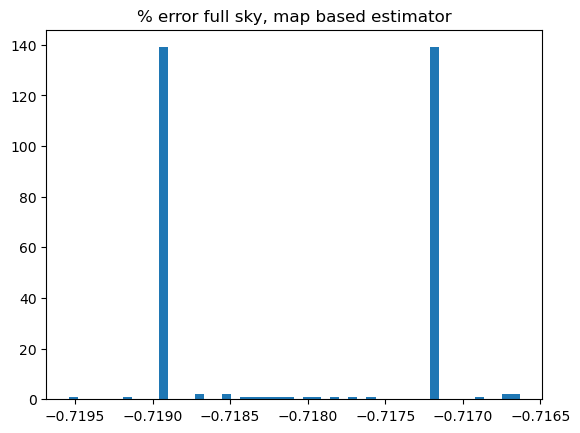

Median of full sky percent error: -0.7968590146922971
Mean of full sky percent error: -0.7277154695133207
Std dev of full sky percent error: 0.09525815740518657


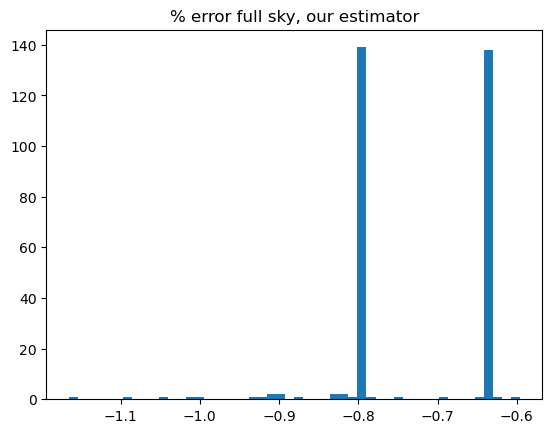

Median of full sky percent error EB estimator: -0.8983266975627513
Mean of full sky percent error EB estimator: -0.8852246685561298
Std dev of full sky percent error EB estimator: 0.18487542633886292


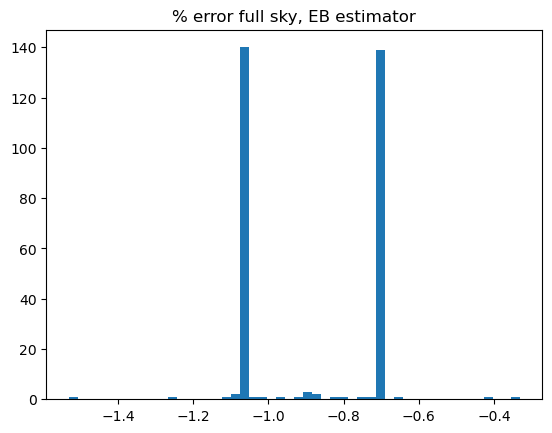

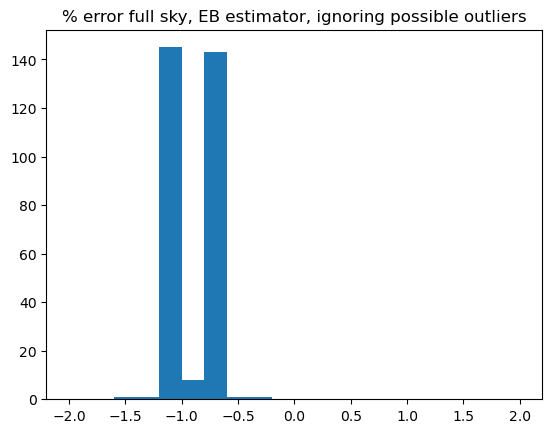

Median of full sky angles Unrot EB estimator: -0.000771771100622165
Mean of full sky angles Unrot EB estimator: -0.0011057823597248318
Std dev of full sky angles Unrot EB estimator: 0.00123864656162544


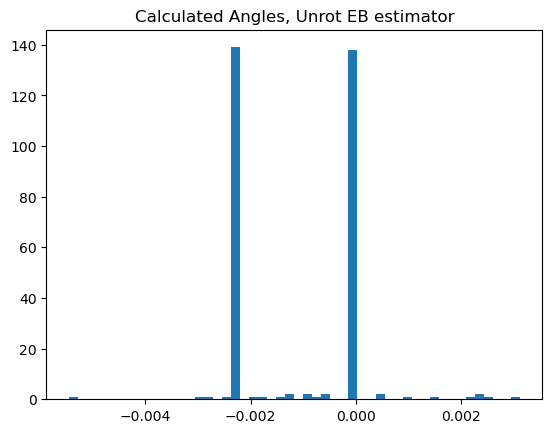

Median of full sky mean TT ratio: 1.000132410924196
Mean of full sky mean TT ratio: 1.0014065349423698
Std dev of full sky mean TT ratio: 0.00147930016879236


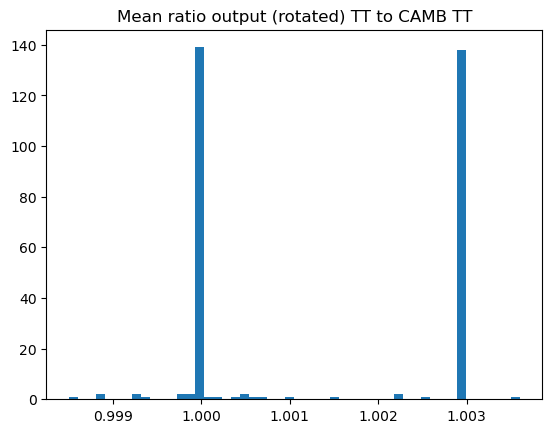

In [62]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff,bins=50)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff,bins=50)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb,bins=50)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only,bins=50)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs,bins=50)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()